## Physics Simulation Tutorial: Contact Mechanics and Rigid Body Dynamics

1. Simple box falling with contact and friction (point mass approximation)
2. Friction models comparison (static vs. dynamic friction)
3. 2D rigid body with rotation (full rigid body dynamics)
4. Compound bodies (T-shaped object with multiple geometries)
5. Circle with rolling friction
6. Mujoco simulation demo
7. Simulation comparison with different integrators

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

In [2]:
# ============================================
# GLOBAL CONFIG AND HELPERS
# ============================================
import os

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def torque_z_2d(rel_vec, force_vec):
    """Return scalar z-torque of 2D cross product r x F (avoids NumPy deprecation)."""
    return rel_vec[0] * force_vec[1] - rel_vec[1] * force_vec[0]

---
## 1. Simple Box Falling with Contact and Friction

### Context
We simulate a box falling under gravity and interacting with the ground.

### Physics Equations

**1. Equations of Motion (Newton's Second Law):**
$$
m \vec{a} = \vec{F}_{\text{total}} = \vec{F}_{\text{gravity}} + \vec{F}_{\text{normal}} + \vec{F}_{\text{friction}}
$$

**2. Gravity Force:**
$$
F_y^{\text{gravity}} = m g
$$

**3. Contact Normal Force (Spring-Damper Model):**
$$
F_n = k \cdot d + c \cdot v_{\text{rel}}
$$
where:
- $d = \max(0, h_{\text{box}} - y)$ is the penetration depth
- $v_{\text{rel}} = -v_y$ is the relative velocity (when in contact)
- $k$ is contact stiffness, $c$ is damping coefficient

**4. Friction Force (Coulomb Friction with Smooth Approximation):**
$$
F_f = -\mu F_n \cdot \tanh(\alpha v_x)
$$
where $\mu$ is the friction coefficient and $\alpha$ controls smoothness

**5. Semi-Implicit Euler Integration:**
$$
\begin{align}
\vec{a}^{(t)} &= \vec{F}^{(t)} / m \\
\vec{v}^{(t+1)} &= \vec{v}^{(t)} + \vec{a}^{(t)} \Delta t \\
\vec{x}^{(t+1)} &= \vec{x}^{(t)} + \vec{v}^{(t+1)} \Delta t
\end{align}
$$

In [3]:
# ============================================
# HYPERPARAMETERS - Modify these to experiment
# ============================================

# Physical properties
MASS = 1.0                    # Mass of the box (kg)
BOX_SIZE = 0.1                # Half-height of the box (m)
GRAVITY = -9.81               # Gravitational acceleration (m/s^2)

# Contact model parameters
FRICTION_COEFF = 0.5          # Coefficient of friction (dimensionless)
CONTACT_STIFFNESS = 10000     # Contact spring stiffness (N/m)
DAMPING_COEFF = 100           # Contact damping coefficient (N·s/m)

# Simulation parameters
TIME_STEP = 0.001             # Integration time step (s)
NUM_STEPS = 4000              # Number of simulation steps
SAVE_EVERY = 10               # log states for animation every 10 timesteps

# Initial conditions
INITIAL_POS = np.array([0.0, 1.0])   # Initial position [x, y] (m)
INITIAL_VEL = np.array([4.0, 0.0])   # Initial velocity [vx, vy] (m/s)

In [4]:
# ============================================
# HELPER FUNCTIONS
# ============================================

def contact_force(y, vy, box_size, k, c):
    """
    Compute normal contact force using spring-damper model.
    
    Args:
        y: Vertical position of box center
        vy: Vertical velocity
        box_size: Half-height of the box
        k: Contact stiffness
        c: Damping coefficient
    
    Returns:
        Normal force magnitude (always non-negative)
    """
    penetration = max(0.0, box_size - y)  # How much the box penetrates the ground
    relative_vel = -vy if y < box_size else 0.0  # Velocity into the surface
    fn = k * penetration + c * relative_vel  # Spring + damper
    return max(fn, 0.0)  # Contact force cannot be negative (no adhesion)

def friction_force(normal_force, vx, mu, smoothness=10):
    """
    Compute friction force using smoothed Coulomb model.
    
    Args:
        normal_force: Magnitude of normal contact force
        vx: Horizontal velocity
        mu: Friction coefficient
        smoothness: Tanh smoothing parameter (higher = sharper transition)
    
    Returns:
        Friction force (opposes motion)
    """
    return -mu * normal_force * np.tanh(smoothness * vx)

In [5]:
# ============================================
# SIMULATION LOOP
# ============================================

# Initialize state
pos = INITIAL_POS.copy()
vel = INITIAL_VEL.copy()
positions = []

# Run simulation
for step in range(NUM_STEPS):
    # 1. Initialize force with gravity
    force = np.array([0.0, MASS * GRAVITY])
    
    # 2. Compute contact normal force
    fn = contact_force(pos[1], vel[1], BOX_SIZE, CONTACT_STIFFNESS, DAMPING_COEFF)
    force[1] += fn  # Add vertical component
    
    # 3. Compute friction force
    ff = friction_force(fn, vel[0], FRICTION_COEFF)
    force[0] += ff  # Add horizontal component
    
    # 4. Semi-implicit Euler integration
    acc = force / MASS
    vel += acc * TIME_STEP      # Update velocity first
    pos += vel * TIME_STEP      # Then update position with new velocity
    
    # 5. Log state
    if step % SAVE_EVERY == 0:
        positions.append(pos.copy())

# Convert to numpy array for easier plotting
positions = np.array(positions)
print(f"Simulation completed: {NUM_STEPS} steps")
print(f"Final position: x={positions[-1, 0]:.3f} m, y={positions[-1, 1]:.3f} m")
print(f"Final velocity: vx={vel[0]:.3f} m/s, vy={vel[1]:.3f} m/s")

Simulation completed: 4000 steps
Final position: x=2.081 m, y=0.099 m
Final velocity: vx=0.000 m/s, vy=-0.000 m/s


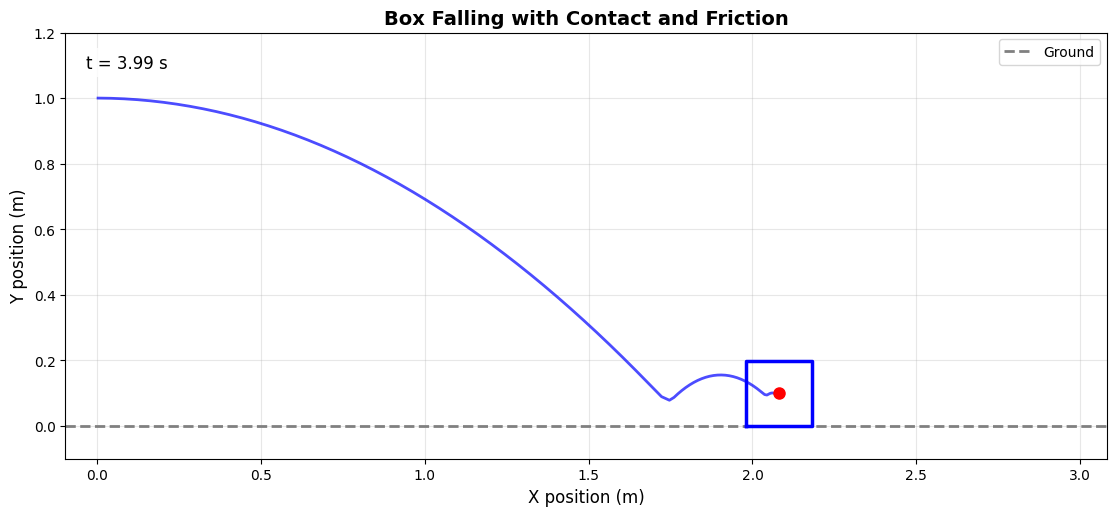

In [6]:
# ============================================
# ANIMATION - Falling Box with Trajectory
# ============================================

# Calculate figure size based on data range
x_range = positions[:, 0].max() - positions[:, 0].min()
y_range = positions[:, 1].max() - positions[:, 1].min()
aspect_ratio = x_range / y_range
# Set height to 5 inches and scale width proportionally
fig_height = 5
fig_width = fig_height * aspect_ratio

# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(positions[:, 0].min() - 0.1, positions[:, 0].max() + 1.0)
ax.set_ylim(-0.1, 1.2)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=2, label='Ground')
ax.set_xlabel('X position (m)', fontsize=12)
ax.set_ylabel('Y position (m)', fontsize=12)
ax.set_title('Box Falling with Contact and Friction', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=10)

# Create animated elements
trajectory, = ax.plot([], [], 'b-', linewidth=2, label='Trajectory', alpha=0.7)
box_marker, = ax.plot([], [], 'ro', markersize=8, label='Box')
box_patch, = ax.plot([], [], 'b-', lw=2.5, label='Box')
timer_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, 
                     ha='left', va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

def init():
    trajectory.set_data([], [])
    box_marker.set_data([], [])
    timer_text.set_text('t = 0.00 s')
    return trajectory, box_marker, timer_text

def animate(i):
    # Update trajectory (show path up to current frame)
    trajectory.set_data(positions[:i+1, 0], positions[:i+1, 1])
    
    # Update box position
    box_marker.set_data([positions[i, 0]], [positions[i, 1]])

    # Update box
    corners_relative = np.array([
        [-BOX_SIZE, -BOX_SIZE],
        [BOX_SIZE, -BOX_SIZE],
        [BOX_SIZE, BOX_SIZE],
        [-BOX_SIZE, BOX_SIZE]
    ])
    corners = positions[i] + corners_relative
    loop = np.vstack([corners, corners[0]])
    box_patch.set_data(loop[:, 0], loop[:, 1])
    
    # Update timer
    time_val = i * TIME_STEP * SAVE_EVERY
    timer_text.set_text(f't = {time_val:.2f} s')
    
    return trajectory, box_marker, timer_text, box_patch

# Create animation
ani = animation.FuncAnimation(
    fig, animate, frames=len(positions),
    init_func=init, blit=True, interval=10
)

# Save animation as GIF
ani.save(os.path.join(RESULTS_DIR, 'falling_box.gif'), writer='pillow', fps=30)

plt.tight_layout()
plt.show()

---
## 2: Friction Models

### Context
This scenario compares different friction models to understand how we approximate the complex physics of friction in simulation.

### Physics Background

**Real-world Friction:**
- **Static friction**: $F_s \leq \mu_s F_n$ (prevents motion when velocity = 0)
- **Kinetic/Dynamic friction**: $F_k = \mu_k F_n$ (opposes motion when sliding)

**Problem**: The discontinuity at $v = 0$ causes numerical instability.

**Solution**: Use a smooth approximation:
$$
F_f = \mu F_n \cdot \tanh(\alpha \cdot v)
$$

This provides:
- Smooth transition near $v = 0$
- Asymptotic behavior: $F_f \rightarrow \mu F_n$ as $v \rightarrow \infty$
- Numerical stability for time integration

In [7]:
# ============================================
# HYPERPARAMETERS - Friction Model
# ============================================

MU_STATIC = 0.8               # Static friction coefficient
MU_KINETIC = 0.6              # Kinetic (sliding) friction coefficient
NORMAL_FORCE = 10.0           # Normal force magnitude (N)
TANH_STEEPNESS = 20           # Steepness of tanh approximation

# Velocity range for plotting
V_MIN = -1.0
V_MAX = 1.0
NUM_POINTS = 500

In [8]:
# ============================================
# COMPUTE FRICTION MODELS
# ============================================

# Velocity array
v = np.linspace(V_MIN, V_MAX, NUM_POINTS)

# Idealized discontinuous model (static/kinetic)
# Uses static friction near zero velocity, kinetic otherwise
ideal_friction = np.where(
    np.abs(v) < 0.01,  # Near-zero velocity threshold
    MU_STATIC * NORMAL_FORCE * np.sign(v),
    MU_KINETIC * NORMAL_FORCE * np.sign(v)
)

# Smooth tanh approximation
smooth_friction = MU_KINETIC * NORMAL_FORCE * np.tanh(TANH_STEEPNESS * v)

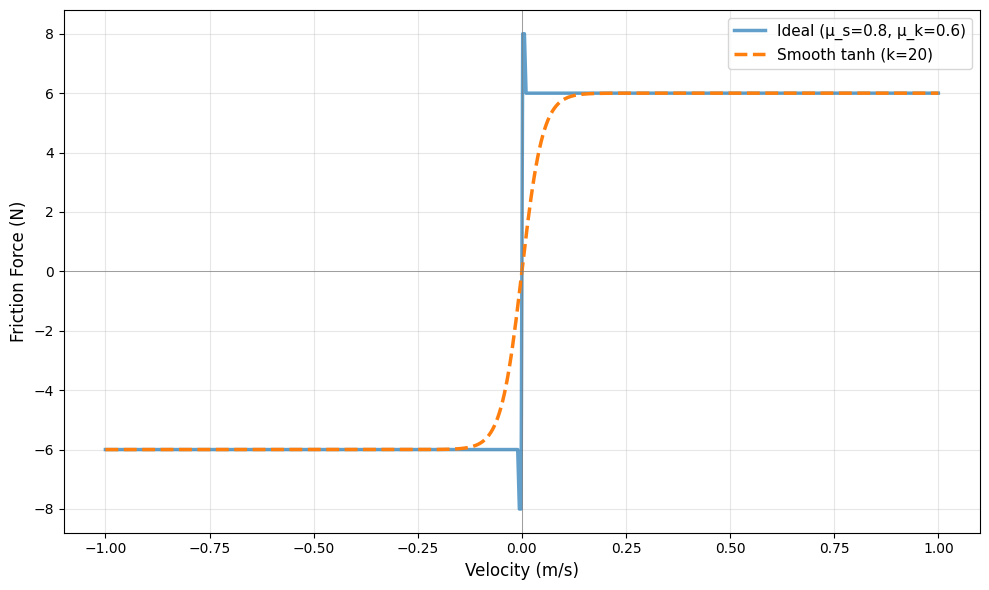

In [9]:
# ============================================
# VISUALIZATION
# ============================================

plt.figure(figsize=(10, 6))
plt.plot(v, ideal_friction, linewidth=2.5, label=f'Ideal (μ_s={MU_STATIC}, μ_k={MU_KINETIC})', alpha=0.7)
plt.plot(v, smooth_friction, linewidth=2.5, label=f'Smooth tanh (k={TANH_STEEPNESS})', linestyle='--')
plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
plt.xlabel('Velocity (m/s)', fontsize=12)
plt.ylabel('Friction Force (N)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## Scenario 1: 2D Rigid Body Box with Rotation

### Context
Now we add rotational dynamics. The box can rotate as it falls, and contact forces are applied at the corners rather than the center of mass.

### Physics Equations

**1. Translational Motion:**
$$
m \vec{a}_{\text{COM}} = \sum \vec{F}_i
$$

**2. Rotational Motion (Planar):**
$$
I \alpha = \sum \tau_i = \sum (\vec{r}_i \times \vec{F}_i)
$$
where $\vec{r}_i$ is the vector from the center of mass to the contact point.

**3. Moment of Inertia (Rectangular Box):**
$$
I_z = \frac{1}{12} m (w^2 + h^2)
$$

**4. Corner Positions (Rotation Matrix):**
$$
\vec{p}_{\text{corner}} = \vec{p}_{\text{COM}} + R(\theta) \vec{r}_{\text{local}}
$$
where $R(\theta) = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$

**5. Point Velocity (with rotation):**
$$
\vec{v}_{\text{point}} = \vec{v}_{\text{COM}} + \vec{\omega} \times \vec{r}
$$
In 2D: $v_x = v_{\text{COM},x} - \omega \cdot r_y$, $v_y = v_{\text{COM},y} + \omega \cdot r_x$

In [10]:
# ============================================
# HYPERPARAMETERS - Rigid Body with Rotation
# ============================================

# Physical properties
MASS_3 = 1.0
BOX_WIDTH = 0.2               # Full width of the box (m)
BOX_HEIGHT = 0.2              # Full height of the box (m)
GRAVITY_3 = -9.81

# Contact parameters
FRICTION_COEFF_3 = 0.5
CONTACT_STIFFNESS_3 = 1e4
DAMPING_COEFF_3 = 200

# Simulation parameters
TIME_STEP_3 = 0.001
NUM_STEPS_3 = 4000
SAVE_EVERY = 10

# Initial conditions
INITIAL_POS_3 = np.array([0.0, 1.0])    # Center of mass position
INITIAL_VEL_3 = np.array([4.0, 0.0])    # Linear velocity
INITIAL_THETA = 0.5                      # Initial rotation angle (radians)
INITIAL_OMEGA = 0.0                      # Initial angular velocity (rad/s)

In [11]:
# ============================================
# HELPER FUNCTIONS - Rigid Body
# ============================================

def get_corners(pos, theta, width, height):
    """
    Compute world coordinates of box corners given center position and orientation.
    
    Args:
        pos: Center of mass position [x, y]
        theta: Rotation angle (radians)
        width: Box width
        height: Box height
    
    Returns:
        Array of 4 corner positions (counter-clockwise from bottom-left)
    """
    # Local corner positions (relative to center)
    dx, dy = width / 2, height / 2
    corners_local = np.array([
        [-dx, -dy],  # Bottom-left
        [ dx, -dy],  # Bottom-right
        [ dx,  dy],  # Top-right
        [-dx,  dy]   # Top-left
    ])
    
    # Rotation matrix from the body frame to the world frame
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    # Transform to world coordinates
    # return corner pos in world frame
    # raise NotImplementedError
    return pos[None, :] + corners_local @ R.T

def contact_force_point(point_pos, point_vel, k, c, mu):
    """
    Compute contact force at a single point.
    
    Args:
        point_pos: Position of the contact point [x, y]
        point_vel: Velocity of the contact point [vx, vy]
        k: Stiffness
        c: Damping
        mu: Friction coefficient
    
    Returns:
        Force vector [fx, fy]
    """
    # Penetration depth (negative y means below ground)
    # Relative velocity into surface
    # Normal force
    # Friction force (horizontal)

    depth = -point_pos[1]
    if depth <= 0:
        return np.array([0.0, 0.0])  # No contact
    
    v_n = point_vel[1]
    Fn = k * depth + c * (-v_n)
    if Fn < 0:
        Fn = 0.0
    
    v_t = point_vel[0]
    kt = 0.02 * k  # Tangential stiffness
    Ft_visc = -kt * v_t
    Ft_lim = mu * Fn
    Ft = np.clip(Ft_visc, -Ft_lim, Ft_lim)
    return np.array([Ft, Fn])
    # raise NotImplementedError

In [12]:
# ============================================
# SIMULATION LOOP - Rigid Body
# ============================================

# Compute moment of inertia
inertia = (1/12) * MASS_3 * (BOX_WIDTH**2 + BOX_HEIGHT**2)

# Initialize state
pos = INITIAL_POS_3.copy()
vel = INITIAL_VEL_3.copy()
theta = INITIAL_THETA
omega = INITIAL_OMEGA

positions_3 = []

# Run simulation
for step in range(NUM_STEPS_3):
    # Initialize forces and torques
    force = np.array([0.0, MASS_3 * GRAVITY_3])
    torque = 0.0
    
    # Get current corner positions
    corners = get_corners(pos, theta, BOX_WIDTH, BOX_HEIGHT)

    rel = corners - pos[None, :]
    corner_vel = vel[None, :] + np.column_stack([-omega * rel[:, 1], omega * rel[:, 0]])
    
    # Check each corner for contact
    for i in range(len(corners)):
        # Vector from COM to corner
        # Velocity of this corner (linear + rotational contribution)
        Fi = contact_force_point(corners[i], corner_vel[i], CONTACT_STIFFNESS_3, DAMPING_COEFF_3, FRICTION_COEFF_3)    
        # Check if corner is in contact with ground
            # Compute contact force
            # Add to total force
            # Add torque (r x F)
        if Fi[0] != 0.0 or Fi[1] != 0.0:
            force += Fi
            torque += torque_z_2d(rel[i], Fi)
    
    # Semi-implicit Euler integration
    # Linear motion
    acc = force / MASS_3
    vel += acc * TIME_STEP_3
    pos += vel * TIME_STEP_3
    
    # Angular motion
    alpha = torque / inertia
    omega += alpha * TIME_STEP_3
    theta += omega * TIME_STEP_3
    
    # Log state
    if step % SAVE_EVERY == 0:
        positions_3.append([pos[0], pos[1], theta])

positions_3 = np.array(positions_3)
print(f"Simulation completed: {NUM_STEPS_3} steps")
print(f"Final position: x={positions_3[-1, 0]:.3f} m, y={positions_3[-1, 1]:.3f} m")
print(f"Final angle: θ={positions_3[-1, 2]:.3f} rad ({np.degrees(positions_3[-1, 2]):.1f}°)")

Simulation completed: 4000 steps
Final position: x=2.673 m, y=0.100 m
Final angle: θ=-1.571 rad (-90.0°)


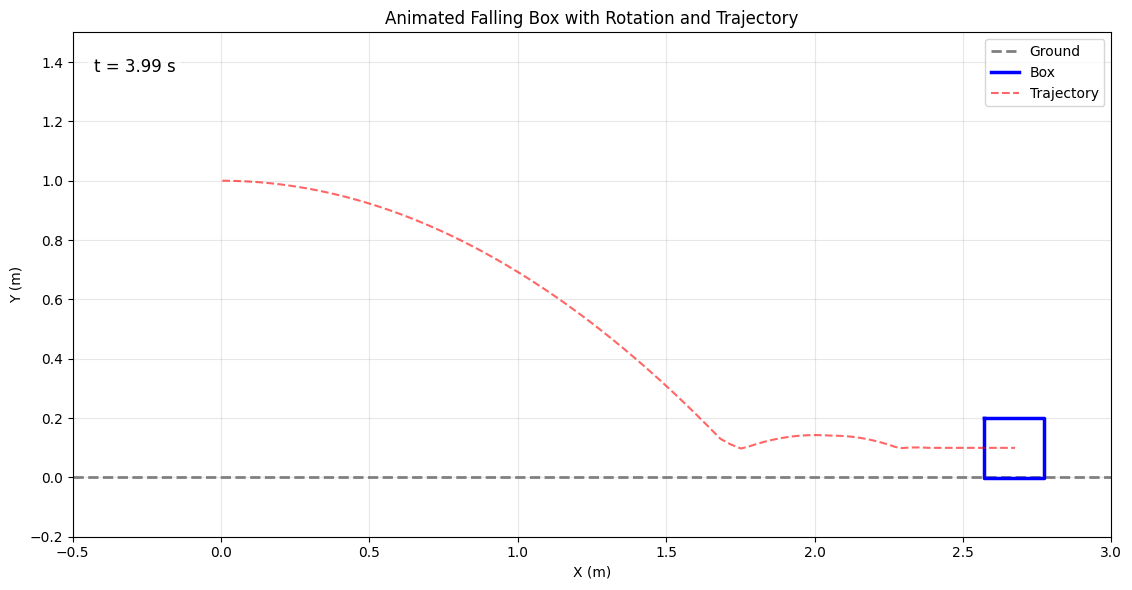

In [13]:
# ============================================
# ANIMATION - Rotating Box with Trajectory
# ============================================

# Calculate figure size based on axis ranges
x_lim = (-0.5, 3)
y_lim = (-0.2, 1.5)
x_range = x_lim[1] - x_lim[0]
y_range = y_lim[1] - y_lim[0]
aspect_ratio = x_range / y_range
fig_height = 6
fig_width = fig_height * aspect_ratio

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_aspect('equal', adjustable='box')

# Precompute times for timer overlay
time_samples_s3 = np.arange(len(positions_3)) * TIME_STEP_3 * SAVE_EVERY
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axhline(0, color='gray', linestyle='--', linewidth=2, label='Ground')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Animated Falling Box with Rotation and Trajectory')
ax.grid(alpha=0.3)

box_patch, = ax.plot([], [], 'b-', lw=2.5, label='Box')
trajectory, = ax.plot([], [], 'r--', lw=1.5, alpha=0.6, label='Trajectory')
timer_text_s3 = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
ax.legend(loc='upper right')

def init():
    box_patch.set_data([], [])
    trajectory.set_data([], [])
    timer_text_s3.set_text('t = 0.00 s')
    return box_patch, trajectory, timer_text_s3

def animate(i):
    pos_i = positions_3[i, :2]
    theta_i = positions_3[i, 2]
    
    # Update box
    corners = get_corners(pos_i, theta_i, BOX_WIDTH, BOX_HEIGHT)
    loop = np.vstack([corners, corners[0]])
    box_patch.set_data(loop[:, 0], loop[:, 1])
    
    # Update trajectory (show path up to current frame)
    trajectory.set_data(positions_3[:i+1, 0], positions_3[:i+1, 1])

    timer_text_s3.set_text(f't = {time_samples_s3[i]:.2f} s')
    
    return box_patch, trajectory, timer_text_s3

ani = animation.FuncAnimation(
    fig, animate, frames=len(positions_3),
    init_func=init, blit=False, interval=10
)

# Save animation with trajectory
ani.save(os.path.join(RESULTS_DIR, 'scenario3_falling_box.gif'), writer='pillow', fps=30)

plt.tight_layout()
plt.show()

---
## Scenario 2: Compound Body (T-Shape)

### Context
Real objects are often composed of multiple simple shapes. Here we simulate a T-shaped object made from two rectangles.

### Physics Equations

**1. Center of Mass (Multiple Bodies):**
$$
\vec{r}_{\text{COM}} = \frac{\sum_i m_i \vec{r}_i}{\sum_i m_i}
$$

**2. Moment of Inertia (Parallel Axis Theorem):**
For each geometry $i$:
$$
I_i = I_{i,\text{local}} + m_i d_i^2
$$
where:
- $I_{i,\text{local}} = \frac{1}{12} m_i (w_i^2 + h_i^2)$ is the local moment of inertia
- $d_i = |\vec{r}_i - \vec{r}_{\text{COM}}|$ is the distance from the geometry center to COM

Total inertia:
$$
I_{\text{total}} = \sum_i I_i
$$

**3. Mass from Density:**
$$
m_i = \rho \cdot A_i = \rho \cdot (w_i \times h_i)
$$

In [14]:
# ============================================
# HYPERPARAMETERS - Compound Body (T-Shape)
# ============================================

# Geometry definitions (two rectangles forming a T)
GEOMS = [
    {
        "offset": np.array([0.0, 0.0]),   # offset from the origin to the center of this geometry in body frame
        "width": 0.2, 
        "height": 0.4
    },   # Vertical stem
    {
        "offset": np.array([0.0, 0.25]),  # offset from the origin to the center of this geometry in body frame
        "width": 0.4, 
        "height": 0.1
    },  # Horizontal bar
]

# Physical parameters
DENSITY = 10.0                # Material density (kg/m²)
GRAVITY_4 = -9.81
FRICTION_COEFF_4 = 0.6
CONTACT_STIFFNESS_4 = 1e4
DAMPING_COEFF_4 = 200

# Simulation parameters
TIME_STEP_4 = 0.001
NUM_STEPS_4 = 4000
PLOT_EVERY = 10               # Save every 10 frames for animation

# Initial conditions
INITIAL_POS_4 = np.array([0.0, 1.0])
INITIAL_VEL_4 = np.array([2.0, 0.0])
INITIAL_THETA_4 = 0.5
INITIAL_OMEGA_4 = 0.0

In [15]:
# ============================================
# COMPUTE MASS PROPERTIES
# ============================================

# Calculate total mass and center of mass
total_mass = 0
com = np.zeros(2)

for geom in GEOMS:
    w, h = geom["width"], geom["height"]
    area = w * h
    m = DENSITY * area
    total_mass += m
    com += m * geom["offset"]

com /= total_mass  # Center of mass position in body frame

# Calculate moment of inertia about COM
inertia_4 = 0

for geom in GEOMS:
    w, h = geom["width"], geom["height"]
    area = w * h
    m = DENSITY * area
    
    # Offset from COM in body frame
    offset = geom["offset"] - com
    
    # Local moment of inertia
    I_local = (1/12) * m * (w**2 + h**2)
    
    # Parallel axis theorem
    I_shift = m * (offset[0]**2 + offset[1]**2)
    
    inertia_4 += I_local + I_shift
    
    # Store mass and adjusted offset in geometry
    geom["mass"] = m
    geom["offset"] = offset  # Now relative to COM

print(f"Total mass: {total_mass:.3f} kg")
print(f"Center of mass: ({com[0]:.3f}, {com[1]:.3f}) m")
print(f"Moment of inertia: {inertia_4:.6f} kg·m²")

Total mass: 1.200 kg
Center of mass: (0.000, 0.083) m
Moment of inertia: 0.035667 kg·m²


In [16]:
# ============================================
# HELPER FUNCTIONS - Compound Body
# ============================================

def get_compound_corners(pos, theta, geoms):
    """
    Get corners for all geometries in the compound body in the world frame.
    
    Args:
        pos: Center of mass position
        theta: Rotation angle
        geoms: List of geometry dictionaries
    
    Returns:
        List of corner arrays (one array per geometry)
    """
    corners_list = []
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

    for g in geoms:
        w, h = g["width"], g["height"]
        dx, dy = w / 2, h / 2
        corners_local = np.array([
            [-dx, -dy],
            [ dx, -dy],
            [ dx,  dy],
            [-dx,  dy]
        ])
        # Transform to world coordinates
        corners_geom = pos[None, :] + (corners_local + g["offset"]) @ R.T
        corners_list.append(corners_geom)
    
    # for geom in geoms:
        # corners in body frame
        # Transform: body frame -(translation)-> COM frame -(rotation+translation)-> world frame
        # corners_geom = ...
        # corners_list.append(corners_geom)
    
    return corners_list

In [17]:
# ============================================
# SIMULATION LOOP - Compound Body
# ============================================

# Initialize state
pos = INITIAL_POS_4.copy()
vel = INITIAL_VEL_4.copy()
theta = INITIAL_THETA_4
omega = INITIAL_OMEGA_4

states_4 = []

# Run simulation
for step in tqdm(range(NUM_STEPS_4), desc="Simulating T-shape"):
    # Initialize forces and torques
    force = np.array([0.0, total_mass * GRAVITY_4])
    torque = 0.0
    
    # Get corners for all geometries
    geom_corners = get_compound_corners(pos, theta, GEOMS)
    
    # Check each corner of each geometry for contact
    for corners in geom_corners:
        for corner in corners:
            # Vector from COM to corner
            rel = corner - pos
            # Velocity of this corner: v = v_{COM} + w x r
            v_corner = vel + np.array([-omega * rel[1], omega * rel[0]])
            
            # Check ground contact
            if corner[1] < 0:
                f = contact_force_point(corner, v_corner, CONTACT_STIFFNESS_4,
                                       DAMPING_COEFF_4, FRICTION_COEFF_4)
                force += f
                torque += torque_z_2d(rel, f)
    
    # Semi-implicit Euler integration
    # Linear motion
    acc = force / total_mass
    vel += acc * TIME_STEP_4
    pos += vel * TIME_STEP_4
    # Angular motion
    alpha = torque / inertia_4
    omega += alpha * TIME_STEP_4
    theta += omega * TIME_STEP_4
    
    # Log state (subsample for animation)
    if step % PLOT_EVERY == 0:
        states_4.append((pos.copy(), theta))

Simulating T-shape: 100%|██████████| 4000/4000 [00:00<00:00, 27584.90it/s]


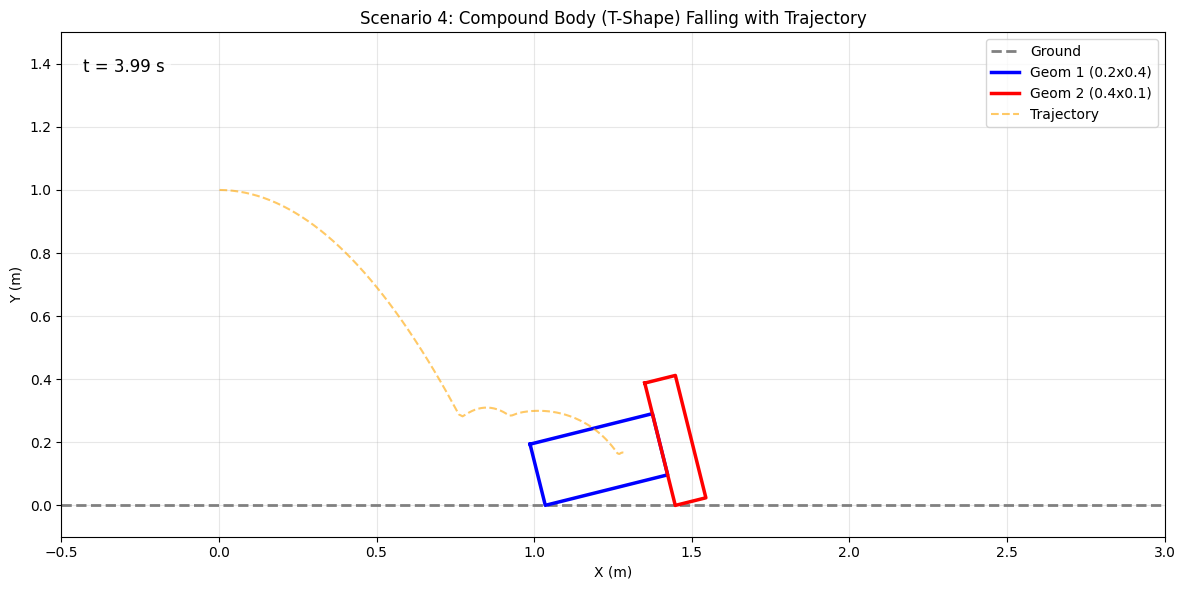

In [18]:
# ============================================
# ANIMATION - T-Shape with Trajectory
# ============================================

# Calculate figure size based on axis ranges
x_lim = (-0.5, 3)
y_lim = (-0.1, 1.5)
x_range = x_lim[1] - x_lim[0]
y_range = y_lim[1] - y_lim[0]
aspect_ratio = x_range / y_range
fig_height = 6
fig_width = fig_height * aspect_ratio

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_aspect('equal', adjustable='box')

# Precompute times for timer overlay
time_samples_s4 = np.arange(len(states_4)) * TIME_STEP_4 * PLOT_EVERY
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axhline(0, color='gray', linestyle='--', linewidth=2, label='Ground')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Scenario 4: Compound Body (T-Shape) Falling with Trajectory')
ax.grid(alpha=0.3)

# Create patches for each geometry
patches = []
colors = ['blue', 'red']  # Different colors for each geometry
for i, geom in enumerate(GEOMS):
    patch, = ax.plot([], [], lw=2.5, color=colors[i], 
                     label=f'Geom {i+1} ({geom["width"]}x{geom["height"]})')
    patches.append(patch)

# Add trajectory line
trajectory, = ax.plot([], [], 'orange', linestyle='--', lw=1.5, alpha=0.6, label='Trajectory')
timer_text_s4 = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

ax.legend(loc='upper right')

def init():
    for patch in patches:
        patch.set_data([], [])
    trajectory.set_data([], [])
    timer_text_s4.set_text('t = 0.00 s')
    return patches + [trajectory, timer_text_s4]

def animate(i):
    pos_i, theta_i = states_4[i]
    corners_list = get_compound_corners(pos_i, theta_i, GEOMS)
    
    # Update each geometry
    for patch, corners in zip(patches, corners_list):
        loop = np.vstack([corners, corners[0]])
        patch.set_data(loop[:, 0], loop[:, 1])
    
    # Update trajectory (show path up to current frame)
    trajectory_positions = np.array([state[0] for state in states_4[:i+1]])
    trajectory.set_data(trajectory_positions[:, 0], trajectory_positions[:, 1])

    timer_text_s4.set_text(f't = {time_samples_s4[i]:.2f} s')
    
    return patches + [trajectory, timer_text_s4]

ani = animation.FuncAnimation(
    fig, animate, frames=len(states_4),
    init_func=init, interval=10, blit=False
)

# Save animation with trajectory
ani.save(os.path.join(RESULTS_DIR, 'scenario4_compound_falling_box.gif'), writer='pillow', fps=30)

plt.tight_layout()
plt.show()

---
## Scenario 3: Circle with Rolling Friction

### Context
Simulating a circle introduces new challenges: continuous contact surfaces and rolling friction. We approximate the circle with many perimeter points.

### Physics Equations

**1. Moment of Inertia (Solid Disk):**
$$
I = \frac{1}{2} m R^2
$$

**2. Rolling Friction Torque:**
$$
\tau_{\text{roll}} = -\mu_{\text{roll}} F_n \cdot \text{sign}(\omega)
$$

**3. Torsional Friction (Pure Spin):**
$$
\tau_{\text{torsion}} = -\mu_{\text{torsion}} F_n \cdot \text{sign}(\omega)
$$

**Note**: Rolling friction differs from sliding friction:
- Sliding: Opposes tangential velocity at contact point
- Rolling: Opposes angular velocity directly
- Torsional: Opposes spinning in place

In [19]:
# ============================================
# HYPERPARAMETERS - Circle with Rolling Friction
# ============================================

# Circle properties
RADIUS = 0.2                  # Circle radius (m)
DISK_HALF_THICKNESS = 0.01    # Half thickness for MuJoCo disk (m)
MASS_5 = 1.0                  # Mass (kg)

# Physical parameters
GRAVITY_5 = -9.81
MU_SLIDE = 0.0                # Sliding friction (set to 0 to isolate rolling effects)
MU_ROLL = 0.01                # Rolling friction coefficient
MU_TORSION = 0.00             # Torsional friction coefficient
CONTACT_STIFFNESS_5 = 1e4
DAMPING_COEFF_5 = 200

# Simulation parameters
TIME_STEP_5 = 0.001
NUM_STEPS_5 = 4000
PLOT_EVERY_5 = 10

# Integration method selection
INTEGRATION_METHOD = 'semi-implicit'  # Options: 'explicit', 'semi-implicit', 'implicit'
# 'explicit': Euler forward (v and x updated with current forces)
# 'semi-implicit': Symplectic Euler (v updated first, then x with new v) - DEFAULT
# 'implicit': Backward Euler (iterative solve for next state)

# Implicit solver parameters
IMPLICIT_MAX_ITERS = 10       # Maximum iterations for implicit solver
IMPLICIT_TOLERANCE = 1e-6     # Convergence tolerance for implicit solver

# Initial conditions
INITIAL_POS_5 = np.array([0.0, 1.0])
INITIAL_VEL_5 = np.array([0.0, 0.0])
INITIAL_THETA_5 = 0.5
INITIAL_OMEGA_5 = 30.0        # High initial spin

# Moment of inertia for solid disk
inertia_5 = 0.5 * MASS_5 * RADIUS**2

In [20]:
# ============================================
# SIMULATION LOOP - Circle
# ============================================

# Initialize state
pos = INITIAL_POS_5.copy()
vel = INITIAL_VEL_5.copy()
theta = INITIAL_THETA_5
omega = INITIAL_OMEGA_5

states_5 = []
omega_history = []  # Track angular velocity over time

def contact_force_with_normal(point_pos, point_vel, k, c, mu):
    """
    Compute contact force and return both force vector and normal magnitude.

    Args: 
        point_pos: position of the contact point to compute.
        point_vel: velocity of the contact point, (vx, vy).
        k: contact stiffness.
        c: contact damping ratio.
        mu: sliding friction coefficient.
    
    Returns:
        (force_vector, normal_force_magnitude)
    """
    d = max(0.0, -point_pos[1])  # penetration depth
    if d <= 0:
        return np.array([0.0, 0.0]), 0.0  # no contact

    v_rel = np.asarray(point_vel, dtype=float)
    v_n = v_rel[1]
    v_t = v_rel[0]
    fn = k * d - c * v_n
    if fn < 0:
        fn = 0.0
    kt = 0.02 * k  # tangential stiffness
    ft_visc = -kt * v_t
    ft = np.clip(ft_visc, -mu * fn, mu * fn)
    return np.array([ft, fn]), fn

for step in range(NUM_STEPS_5):

    force_total = np.array([0.0, MASS_5 * GRAVITY_5])
    torque_total = 0.0
    
    # TODO: use multiple contact points uniformly distributed around the circle
    rel = np.array([0, -RADIUS])  # use only one contact point
    contact_point = pos + rel
    
    # check if contact point is in contact with the ground
    if contact_point[1] < 0:
        v_point = vel + np.array([-omega * rel[1], omega * rel[0]])
        f_contact, fn = contact_force_with_normal(
            contact_point, 
            v_point,
            CONTACT_STIFFNESS_5,
            DAMPING_COEFF_5,
            MU_SLIDE
        )
        force_total += f_contact
        torque_total += torque_z_2d(rel, f_contact)
        normal_force = fn

        if normal_force > 0:
            rolling_torque = -MU_ROLL * normal_force * RADIUS * np.sign(omega)
            torque_total -= rolling_torque
    
    # Integration
    acc = force_total / MASS_5
    alpha = torque_total / inertia_5
    pos += vel * TIME_STEP_5
    theta += omega * TIME_STEP_5
    vel += acc * TIME_STEP_5
    omega += alpha * TIME_STEP_5

    if step % PLOT_EVERY_5 == 0:
        states_5.append((pos.copy(), theta))
        omega_history.append(omega)

omega_history = np.array(omega_history)

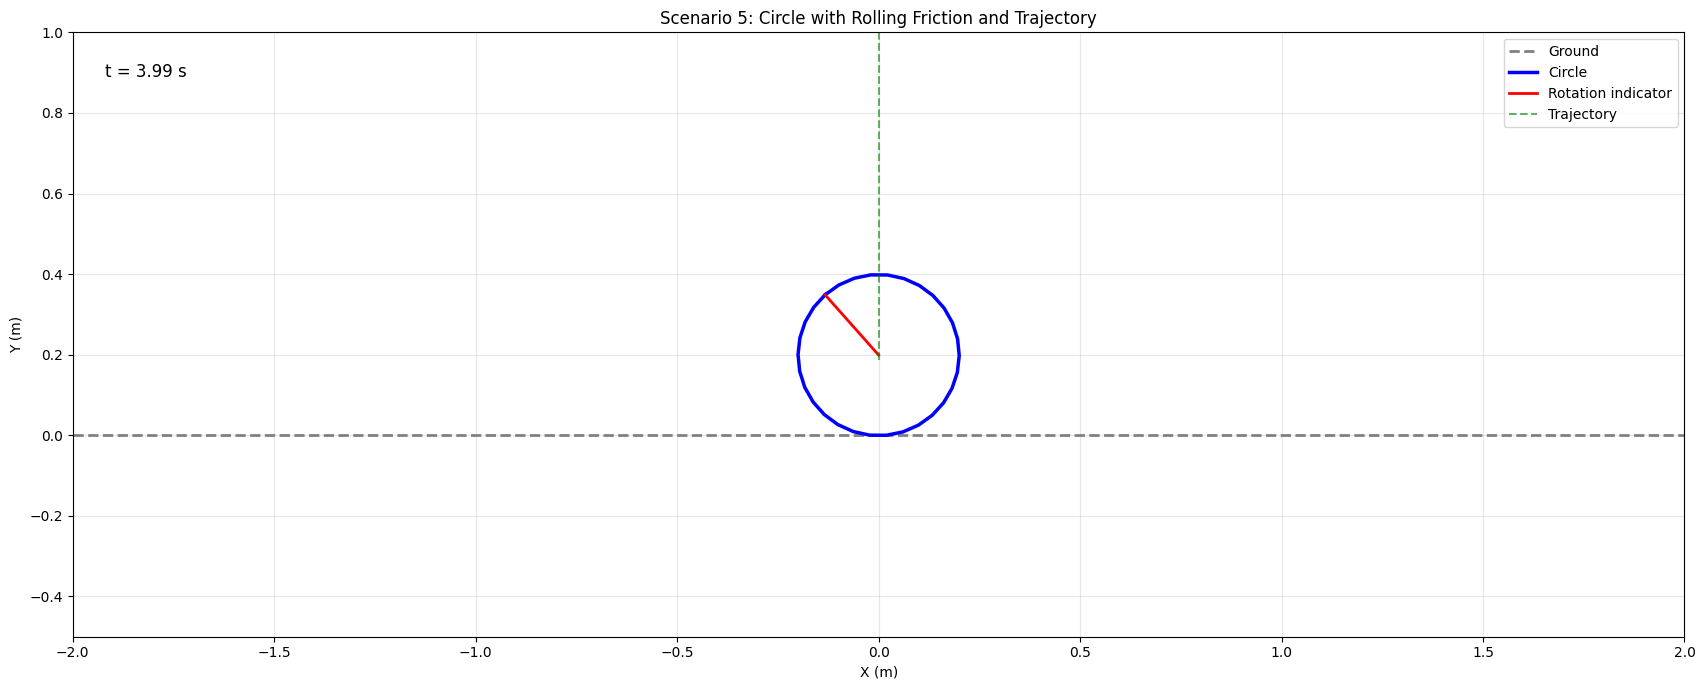

In [21]:
# ============================================
# ANIMATION - Circle with Trajectory
# ============================================

# Calculate figure size based on axis ranges
x_lim = (-2.0, 2.0)
y_lim = (-0.5, 1.0)
x_range = x_lim[1] - x_lim[0]
y_range = y_lim[1] - y_lim[0]
aspect_ratio = x_range / y_range
fig_height = 7
fig_width = fig_height * aspect_ratio  # Will be square since aspect_ratio = 1

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_aspect('equal', adjustable='box')

# Precompute times for timer overlay
time_samples = np.arange(len(states_5)) * TIME_STEP_5 * PLOT_EVERY_5
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axhline(0, color='gray', linestyle='--', linewidth=2, label='Ground')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Scenario 5: Circle with Rolling Friction and Trajectory')
ax.grid(alpha=0.3)

circle_patch, = ax.plot([], [], 'b-', lw=2.5, label='Circle')
timer_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
radius_line, = ax.plot([], [], 'r-', lw=2, label='Rotation indicator')
trajectory, = ax.plot([], [], 'green', linestyle='--', lw=1.5, alpha=0.6, label='Trajectory')
ax.legend(loc='upper right')


angles = np.linspace(0, 2 * np.pi, 30, endpoint=False)
circle_local_points = np.stack([
    RADIUS * np.cos(angles),
    RADIUS * np.sin(angles)
], axis=1)

def get_circle_points(pos, theta, local_points):
    """
    Transform local circle points to world coordinates.
    
    Args:
        pos: Center position
        theta: Rotation angle
        local_points: Local point coordinates
    
    Returns:
        Transformed points in world frame
    """
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    return local_points @ R.T + pos

def init():
    circle_patch.set_data([], [])
    radius_line.set_data([], [])
    trajectory.set_data([], [])
    timer_text.set_text('t = 0.00 s')
    return circle_patch, radius_line, trajectory, timer_text

def animate(i):
    pos_i, theta_i = states_5[i]
    
    # Circle perimeter
    pts = get_circle_points(pos_i, theta_i, circle_local_points)
    loop = np.vstack([pts, pts[0]])
    circle_patch.set_data(loop[:, 0], loop[:, 1])
    
    # Radius line to show rotation
    end_point = pos_i + RADIUS * np.array([np.cos(theta_i), np.sin(theta_i)])
    radius_line.set_data([pos_i[0], end_point[0]], [pos_i[1], end_point[1]])
    
    # Update trajectory (show path up to current frame)
    trajectory_positions = np.array([state[0] for state in states_5[:i+1]])
    trajectory.set_data(trajectory_positions[:, 0], trajectory_positions[:, 1])

    timer_text.set_text(f't = {time_samples[i]:.2f} s')
    
    return circle_patch, radius_line, trajectory, timer_text

ani = animation.FuncAnimation(
    fig, animate, frames=len(states_5),
    init_func=init, interval=10, blit=False
)

# Save animation with trajectory
ani.save(os.path.join(RESULTS_DIR, 'scenario5_falling_circle.gif'), writer='pillow', fps=30)

plt.tight_layout()
plt.show()

---
## 6: Using MuJoCo Physics Engine

So far, we've built physics simulations from scratch to understand the fundamental principles. However, professional robotics and animation applications use specialized physics engines like **MuJoCo** (Multi-Joint dynamics with Contact) that provide:

- **High performance**: Optimized C++ implementation
- **Advanced contact models**: More sophisticated than our simple spring-damper
- **Built-in solvers**: Handles complex constraints and contacts automatically

MuJoCo uses XML to define physical models.
- **`<worldbody>`**: Contains all objects in the scene
- **`<geom>`**: Geometric shapes (sphere, box, plane, etc.)
- **`<body>`**: Rigid bodies that can have mass and inertia
- **`<option>`**: Simulation settings (gravity, timestep, integrator)

In [22]:
# ============================================
# MUJOCO MODEL DEFINITION (XML)
# ============================================

# Calculate MuJoCo contact parameters from custom implementation
# Custom: F = k*d + c*v where k=stiffness, c=damping
# MuJoCo solref: [timeconst, dampratio]
#   timeconst = sqrt(m/k)
#   dampratio = c / (2*sqrt(m*k))  where 1.0 = critically damped

k = CONTACT_STIFFNESS_5  # 1e4 N/m
c = DAMPING_COEFF_5      # 200 N·s/m
m = MASS_5               # 1.0 kg

timeconst = np.sqrt(m / k)
dampratio = c / (2 * np.sqrt(m * k))

inertia_disk_axis = 0.5 * MASS_5 * RADIUS**2
inertia_disk_diameter = 0.25 * MASS_5 * RADIUS**2 + (1.0/12.0) * MASS_5 * (2 * DISK_HALF_THICKNESS)**2

# Define the MuJoCo model as an XML string (using friction coefficients from Scenario 5)
mujoco_xml = f"""
<mujoco model="rolling_disk">
    <!-- Compiler settings -->
    <compiler angle="radian" coordinate="local"/>
    
    <!-- Simulation options -->
    <option timestep="{TIME_STEP_5}" gravity="0 0 {GRAVITY_5}" integrator="Euler">
        <flag warmstart="disable"/>
    </option>
    
    <!-- Contact parameters matching custom implementation -->
    <default>
        <geom friction="{MU_SLIDE} {MU_TORSION} {MU_ROLL}" condim="6" solimp="0.99 0.995 0.001" solref="{timeconst} {dampratio}"/>
        <!--
        friction: [slide, torsional, rolling]
        # condim=6 activates sliding+torsional+rolling friction so damping matches the 2D model
        solimp: contact impedance [dmin dwidth midpoint power]  -> strong contact constraints
        solref: [timeconst, dampratio]
          timeconst = sqrt(mass/stiffness) = {timeconst:.6f}
          dampratio = damping/(2*sqrt(mass*stiffness)) = {dampratio:.6f}
        Matches custom: stiffness={k}, damping={c}
        -->
    </default>
    
    <!-- Assets (materials for visualization) -->
    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="512"/>
        <texture name="grid" type="2d" builtin="checker" rgb1="0.2 0.2 0.2" rgb2="0.3 0.3 0.3" width="512" height="512"/>
        <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0.2"/>
    </asset>
    
    <!-- World body (fixed objects) -->
    <worldbody>
        <!-- Ground plane -->
        <geom name="ground" type="plane" size="5 5 0.1" rgba="0.5 0.5 0.5 1" material="grid"/>
        
        <!-- Light source -->
        <light directional="true" diffuse="0.8 0.8 0.8" specular="0.2 0.2 0.2" pos="0 0 5" dir="0 0 -1"/>
        
        <!-- Thin disk (wheel) -->
        <body name="disk" pos="0 0 {INITIAL_POS_5[1]}">
            <inertial pos="0 0 0" mass="{MASS_5}" diaginertia="{inertia_disk_diameter:.6f} {inertia_disk_axis:.6f} {inertia_disk_diameter:.6f}"/>
            <!-- Disk geometry: cylinder with axle along Y-axis -->
            <geom name="disk_geom" type="cylinder" size="{RADIUS} {DISK_HALF_THICKNESS}" euler="1.57079632679 0 0" rgba="0.2 0.4 0.8 1"/>
            <!-- Visual indicator to show disk rotation -->
            <geom name="disk_indicator" type="capsule" fromto="0 0 0  {RADIUS} 0 0" size="0.01" density="0" contype="0" conaffinity="0" rgba="1 0.2 0.2 1"/>
            
            <!-- Initial velocity (set via qvel in simulation) -->
            <freejoint/>
        </body>
    </worldbody>
</mujoco>
"""

with open("rolling_disk_model.xml", "w") as f:
    f.write(mujoco_xml)

In [23]:
# ============================================
# LOAD MUJOCO MODEL
# ============================================

import mujoco
print(f"MuJoCo version: {mujoco.__version__}")

# Load model from XML string
model = mujoco.MjModel.from_xml_string(mujoco_xml)
data = mujoco.MjData(model)

MuJoCo version: 3.3.7


In [24]:
# ============================================
# RUN MUJOCO SIMULATION
# ============================================

# Simulation parameters (matching Scenario 5)
num_steps_mj = 4000
save_every = PLOT_EVERY_5

# Set initial conditions
# MuJoCo uses Z-up coordinate system (X-Y horizontal, Z vertical)
# Custom sim uses Y-up coordinate system (X horizontal, Y vertical, Z horizontal)
# Coordinate mapping: Custom (X,Y,Z) -> MuJoCo (X,Z,Y)
# Position: [x, y, z] and quaternion [w, x, y, z]
data.qpos[0:3] = [0.0, 0.0, 1.0]
data.qpos[3:7] = [1.0, 0.0, 0.0, 0.0]  # Quaternion (identity rotation)

# Velocity: [linear_x, linear_y, linear_z, angular_x, angular_y, angular_z]
# Custom rotates around out-of-plane axis -> MuJoCo axis is Y
data.qvel[0:3] = [0.0, 0.0, 0.0]  # Linear velocity
data.qvel[3:6] = [0.0, -INITIAL_OMEGA_5, 0.0]  # Angular velocity about MuJoCo Y-axis (matches 2D wheel)

# Storage for trajectory
positions_mj = []
orientations_mj = []
omega_mj_history = []  # Track angular velocity over time

# Run simulation
print("Running MuJoCo simulation...")
for step in range(num_steps_mj):
    # Step the simulation forward
    mujoco.mj_step(model, data)        
    
    # Save state every N steps
    if step % save_every == 0:
        # Get sphere position (first 3 elements of qpos)
        pos = data.qpos[0:3].copy()
        positions_mj.append(pos)
        
        # Get orientation quaternion (next 4 elements)
        quat = data.qpos[3:7].copy()
        orientations_mj.append(quat)
        
        # Get angular velocity (qvel[3:6])
        # Custom sim: rotation around out-of-plane axis (omega scalar)
        # MuJoCo: 2D spin maps to -Y axis; rolling friction uses this component
        omega_mj = -data.qvel[4]
        omega_mj_history.append(omega_mj)

# Convert to numpy arrays
positions_mj = np.array(positions_mj)
orientations_mj = np.array(orientations_mj)
omega_mj_history = np.array(omega_mj_history)

print(f"Final position: x={positions_mj[-1, 0]:.3f}, y={positions_mj[-1, 1]:.3f}, z={positions_mj[-1, 2]:.3f}")
print(f"Final angular velocity vector: {data.qvel[3:6]}")
print(f"Final angular velocity (custom convention): {omega_mj:.3f} rad/s")

Running MuJoCo simulation...
Final position: x=0.000, y=-0.000, z=0.200
Final angular velocity vector: [-2.20341129e-11 -1.03747705e+01  8.66676301e-11]
Final angular velocity (custom convention): 10.425 rad/s


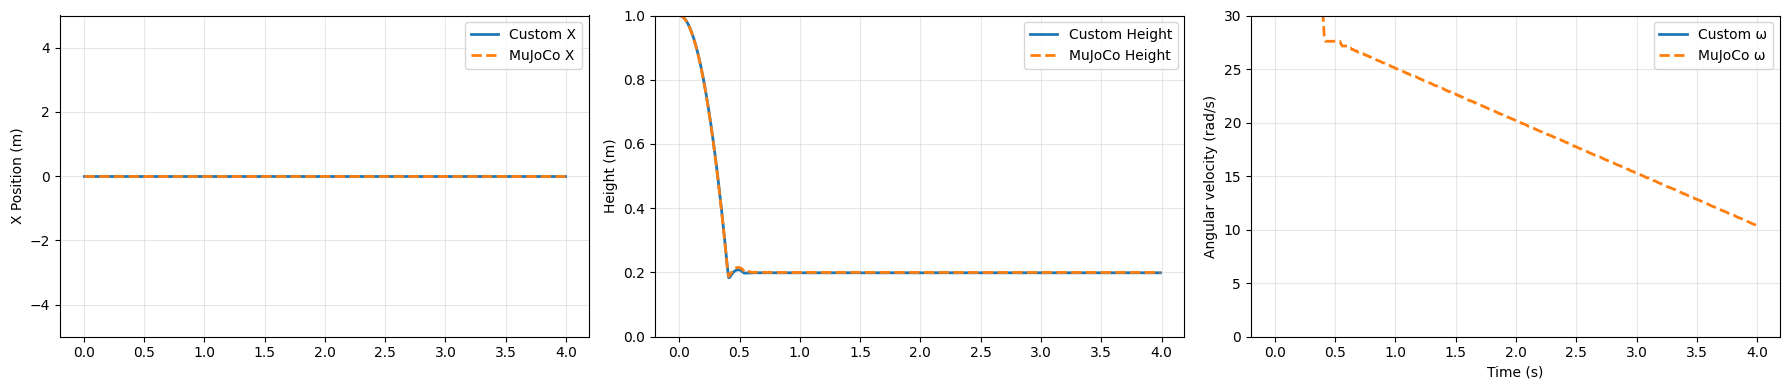

In [25]:
# ============================================
# CUSTOM VS MUJOCO COMPARISON
# ============================================

time_custom = np.arange(len(states_5)) * TIME_STEP_5 * PLOT_EVERY_5
time_mujoco = np.arange(len(positions_mj)) * TIME_STEP_5 * save_every

custom_positions = np.array([state[0] for state in states_5])
custom_theta = np.array([state[1] for state in states_5])

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

axes[0].plot(time_custom, custom_positions[:, 0], label='Custom X', linewidth=2)
axes[0].plot(time_mujoco, positions_mj[:, 0], '--', label='MuJoCo X', linewidth=2)
axes[0].set_ylabel('X Position (m)')
axes[0].set_ylim(-5, 5)
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(time_custom, custom_positions[:, 1], label='Custom Height', linewidth=2)
axes[1].plot(time_mujoco, positions_mj[:, 2], '--', label='MuJoCo Height', linewidth=2)
axes[1].set_ylabel('Height (m)')
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.3)
axes[1].legend()

axes[2].plot(time_custom, omega_history, label='Custom ω', linewidth=2)
axes[2].plot(time_mujoco, omega_mj_history, '--', label='MuJoCo ω', linewidth=2)
axes[2].set_ylim(0, 30)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Angular velocity (rad/s)')
axes[2].grid(alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

In [26]:
# ============================================
# MUJOCO RENDERING
# ============================================

# Create renderer
renderer = mujoco.Renderer(model, height=480, width=640)

# Reset simulation for rendering
mujoco.mj_resetData(model, data)

# Set initial conditions again (Z-up coordinate system)
# Custom 2D axis maps to MuJoCo -Y (rolling axis)
data.qpos[0:3] = [0.0, 0.0, 1.0]  # Position: Z=1.0m (vertical)
data.qpos[3:7] = [1.0, 0.0, 0.0, 0.0]  # Quaternion (identity)
data.qvel[0:3] = [0.0, 0.0, 0.0]  # Linear velocity
data.qvel[3:6] = [0.0, -INITIAL_OMEGA_5, 0.0]  # Angular velocity about MuJoCo Y-axis (matches 2D wheel)

# Storage for rendered frames
frames = []
render_every = 20  # Render every N steps to save memory

for step in tqdm(range(num_steps_mj), desc="Rendering"):
    # Step simulation
    mujoco.mj_step(model, data)
    
    # Render frame periodically
    if step % render_every == 0:
        # Update renderer
        renderer.update_scene(data)
        
        # Render and capture frame
        pixels = renderer.render()
        frames.append(pixels.copy())

# Clean up renderer
renderer.close()

Rendering: 100%|██████████| 4000/4000 [00:02<00:00, 1834.15it/s]


In [27]:
# ============================================
# MUJOCO HTML5 VIEWER
# ============================================

from IPython.display import HTML, display
    
print("\nGenerating HTML5 video from rendered frames...")

# Create video from frames using matplotlib animation
fig_html, ax_html = plt.subplots(figsize=(10, 7.5))
ax_html.axis('off')
im_html = ax_html.imshow(frames[0])
frame_times = np.arange(len(frames)) * render_every * TIME_STEP_5
timer_html = ax_html.text(0.02, 0.95, '', transform=ax_html.transAxes, fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

def animate_html(i):
    im_html.set_data(frames[i])
    timer_html.set_text(f't = {frame_times[i]:.2f} s')
    return [im_html, timer_html]

ani_html = animation.FuncAnimation(
    fig_html, animate_html, frames=len(frames),
    interval=50, blit=True
)

# Convert to HTML5 video
html_video = ani_html.to_html5_video()

# Display in notebook
display(HTML(html_video))

plt.close(fig_html)


Generating HTML5 video from rendered frames...


## 6. Numerical Integration Methods

#### **1. Explicit Euler** (`'explicit'`)
$$\vec{x}^{(t+1)} = \vec{x}^{(t)} + \vec{v}^{(t)} \Delta t, \quad \vec{v}^{(t+1)} = \vec{v}^{(t)} + \vec{a}^{(t)} \Delta t$$

#### **2. Semi-implicit Euler** (`'semi-implicit'`)
$$\vec{v}^{(t+1)} = \vec{v}^{(t)} + \vec{a}^{(t)} \Delta t, \quad \vec{x}^{(t+1)} = \vec{x}^{(t)} + \vec{v}^{(t+1)} \Delta t$$

#### **3. Implicit Euler** (`'implicit'`)
$$\vec{v}^{(t+1)} = \vec{v}^{(t)} + \vec{a}^{(t+1)} \Delta t, \quad \vec{x}^{(t+1)} = \vec{x}^{(t)} + \vec{v}^{(t+1)} \Delta t$$

*How to solve for $\vec{a}^{(t+1)}$?*
1. the system dynamics is known, i.e., $m\,\vec{a} = f(\vec{x}, \vec{v})$
- solve the equation $\vec{a}^{(t+1)} = f(\vec{x}^{(t+1)}, \vec{v}^{(t+1)})$, i.e. $\vec{a}^{(t+1)} = m^{-1} f(\vec{x}^{t} + \vec{v}^{(t+1)} \Delta t, \vec{v}^{(t)} + \vec{a}^{(t+1)} \Delta t)$ (linearize the system dynamics)
2. the system dynamics is unknown
- approximate the Jacobians using finite differntial equation.
- solve via the fixed-point iteration.
    (a) Start with a guess $a^{(t+1)}_{0} = a_t$, and iterate:
    $a^{(t+1)}_{k+1} = M^{-1}f(q^{(t)} + (v^{(t)} + a^{(t+1)}_{k}\Delta t)\Delta t, v^{(t)} + a^{(t+1)}_{k}\Delta t)$.
    (b) Keep updating until convergence.

Compare
- **Stability**: How each method handles stiff contacts (use larger time step or larger stiffness)
- **Energy Conservation**: Differences in energy conservation (use larger time step)

/tmp/ipykernel_247669/1380884300.py:43: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  torque_total += np.cross(rel, f_contact)


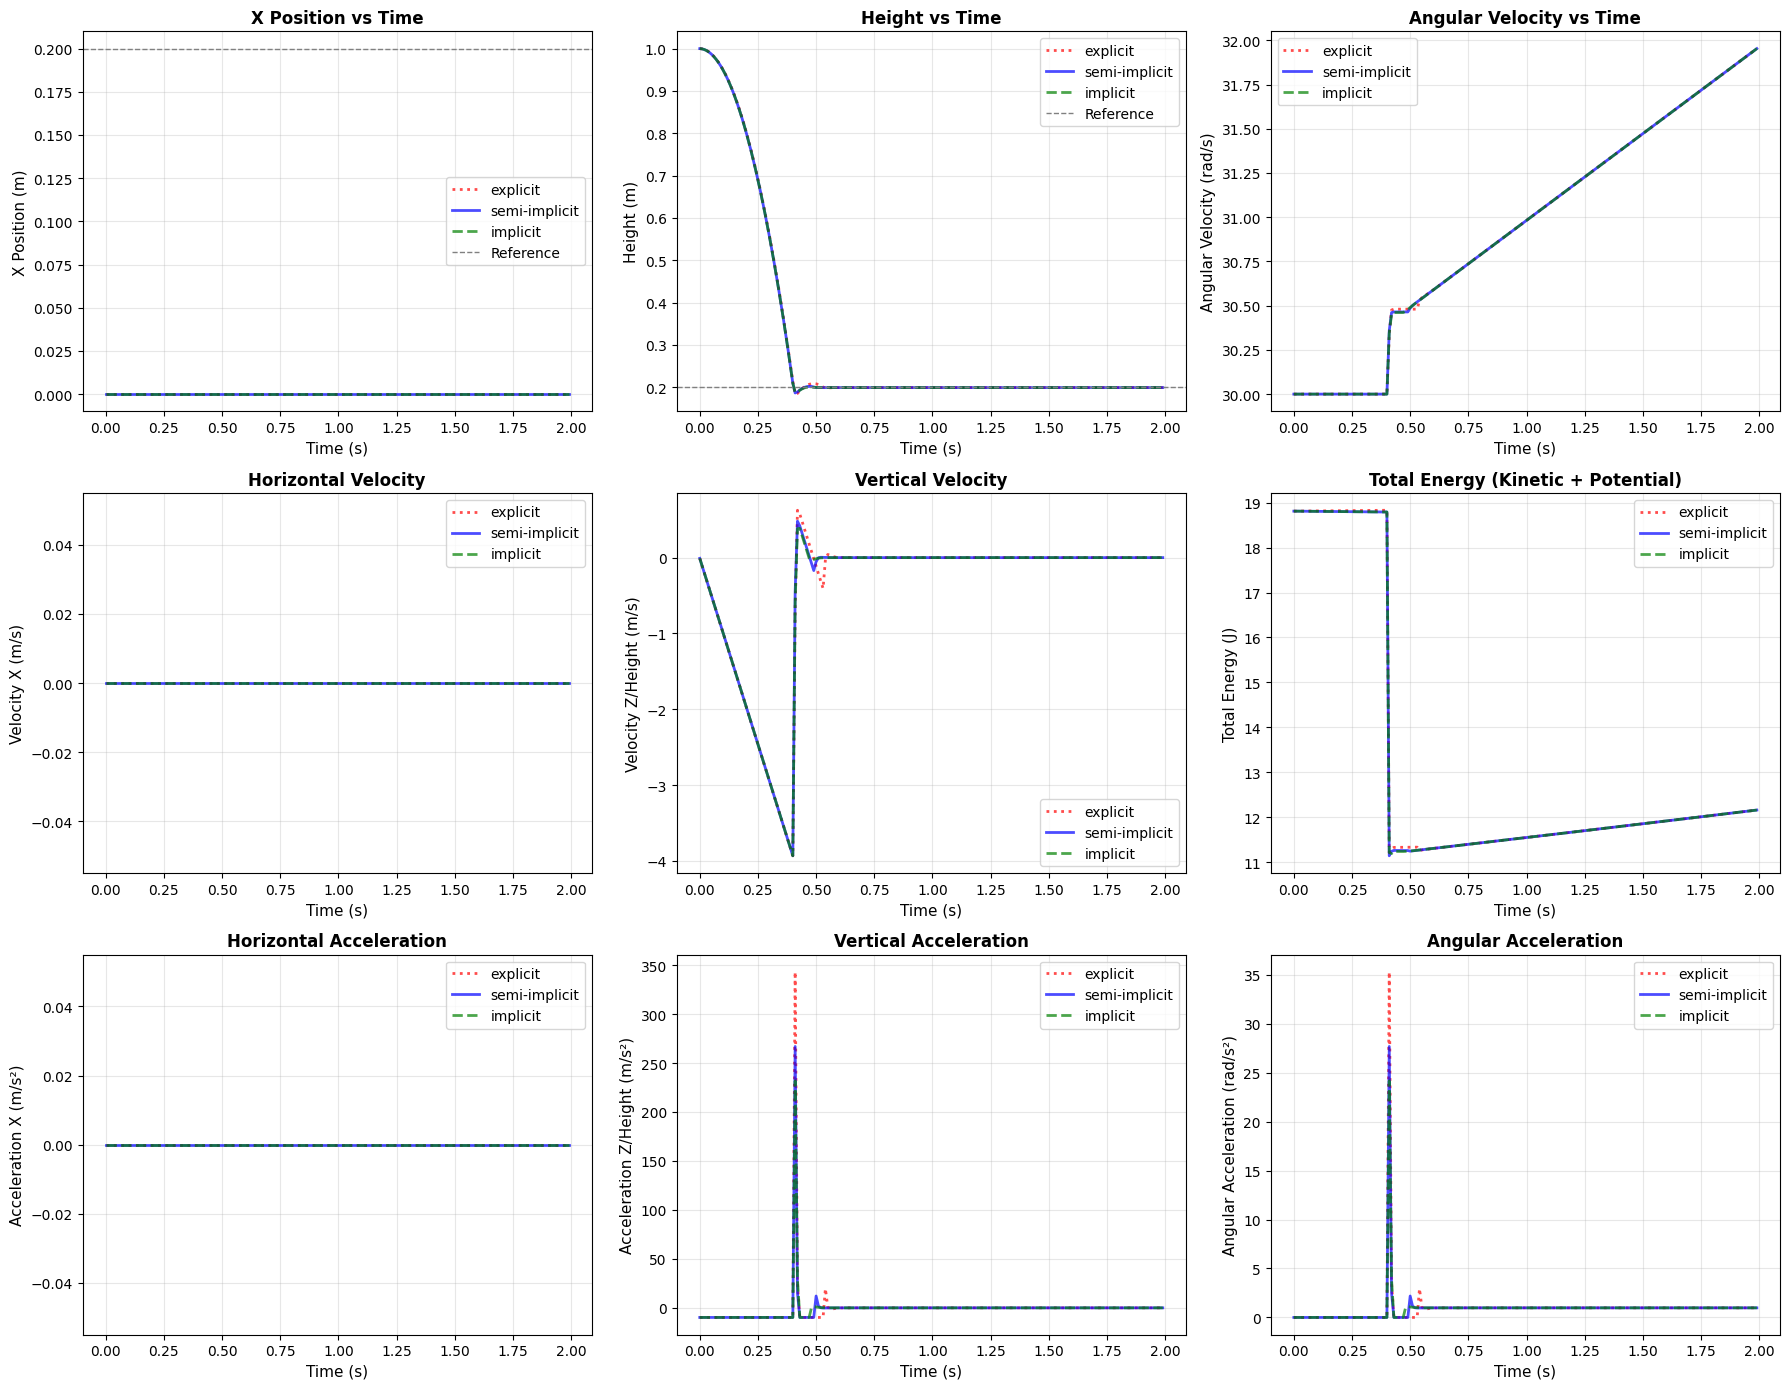

In [28]:
# ============================================
# COMPARE INTEGRATION METHODS
# ============================================

# TODO: implement all integration methods used for later sections
from utils import (
    compare_integration_methods,
    plot_integration_comparison
)

TS = 0.001                   # change to 0.005
NS = int(2 / TS)
INIT_OMEGA = 30.0            # change to 300.0
MU_SLIDE = 0.0               # change to 0.1
CONTACT_STIFFNESS_5 = 1e4    # change to 1e5

# Prepare initial state
initial_state = {
    'pos': INITIAL_POS_5.copy(),
    'vel': INITIAL_VEL_5.copy(),
    'theta': INITIAL_THETA_5,
    'omega': INIT_OMEGA
}

def compute_contact_forces(pos_eval, vel_eval, theta_eval, omega_eval):
    """Compute force/torque using the symmetric contact point beneath the center."""
    force_total  = np.array([0.0, MASS_5 * GRAVITY_5], dtype=float)
    torque_total = 0.0

    rel = np.array([0.0, -RADIUS], dtype=float)  # use only one contact point
    contact_point = pos_eval + rel

    if contact_point[1] < 0:
        v_point = vel_eval + np.array([-omega_eval * rel[1], omega_eval * rel[0]], dtype=float)
        f_contact, fn = contact_force_with_normal(
            contact_point, 
            v_point,
            CONTACT_STIFFNESS_5,
            DAMPING_COEFF_5,
            MU_SLIDE
        )
        force_total += f_contact
        torque_total += np.cross(rel, f_contact)
        normal_force = fn

        if normal_force > 0:
            rolling_torque = -MU_ROLL * normal_force * RADIUS * np.sign(omega_eval)
            torque_total -= rolling_torque

    return force_total, torque_total

# Run comparison
methods_to_test = ['explicit', 'semi-implicit', 'implicit']
integration_results = compare_integration_methods(
    methods_to_test=methods_to_test,
    initial_state=initial_state,
    num_steps=NS,
    dt=TS,
    mass=MASS_5,
    inertia=inertia_5,
    compute_forces_func=compute_contact_forces,
    save_every=PLOT_EVERY_5,
    max_iters=IMPLICIT_MAX_ITERS,
    tol=IMPLICIT_TOLERANCE,
    verbose=False
)

# Plot comparison (includes position, velocity, energy, and acceleration plots)
fig = plot_integration_comparison(
    integration_results,
    dt=TS,
    save_every=PLOT_EVERY_5,
    radius=RADIUS,
    mass=MASS_5,
    inertia=inertia_5,
    gravity=GRAVITY_5
)
plt.show()